# Insurance Company's Accident Damage Prediction Using Catboost
In this notebook we are going to predict accident damage using catboost regressor.

### About dataset
Dataset consists of two parts, train and test. There are 132 features.


We have categorical and numerical features. categorical features are coded and we dont have its actuall values.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import seaborn as sns

### Train data
loss column is the target.

In [13]:
data_train = pd.read_csv('train.csv')
data_train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
data_train.shape

(188318, 132)

No Missing values

In [8]:
data_train.isna().sum().sum()

0

### Test data
No target here.

In [11]:
data_test = pd.read_csv('test.csv')
data_test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [14]:
data_test.shape

(125546, 131)

No missing values

In [15]:
data_test.isna().sum().sum()

0

In [16]:
data_train['isTrain'] = True
data_test['isTrain'] = False

In [17]:
data = pd.concat([data_train, data_test], axis=0)

In [18]:
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,isTrain
0,1,A,B,A,B,A,A,A,A,B,...,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,True
1,2,A,B,A,A,A,A,A,A,B,...,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,True
2,5,A,B,A,A,B,A,A,A,B,...,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,True
3,10,B,B,A,B,A,A,A,A,B,...,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85,True
4,11,A,B,A,B,A,A,A,A,B,...,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85,True


In [19]:
data.shape

(313864, 133)

Extracting categorical indices for catboost regressor

In [20]:
import re

In [22]:
cat_pattern = re.compile("^cat([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")
cont_pattern = re.compile("^cont([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")
cat_col = sorted([cat for cat in data_train.columns if 'cat' in cat], key=lambda s: int(s[3:]))

In [23]:
len(cat_col)

116

In [24]:
cat_index = [i for i in range(0, len(data_train.columns)) if cat_pattern.match(data_train.columns[i])]

In [25]:
len(cat_index)

116

### Visualize target

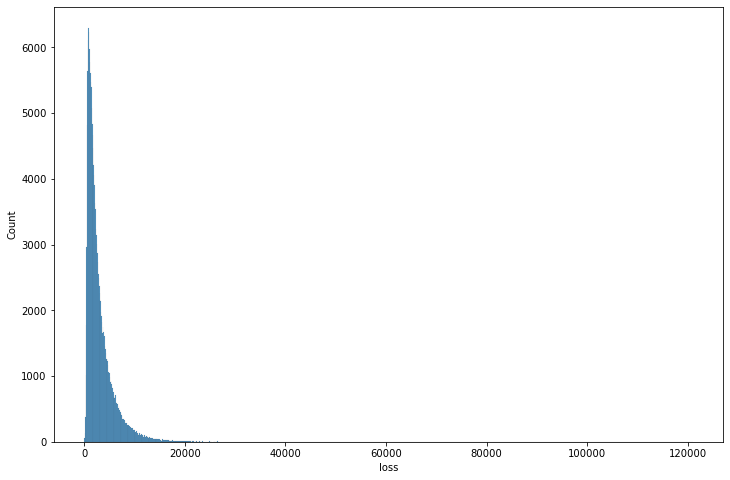

In [28]:
plt.figure(figsize=(12, 8))
sns.histplot(data_train['loss'])
plt.show()

The target is skewed and we apply log function to normalize it.

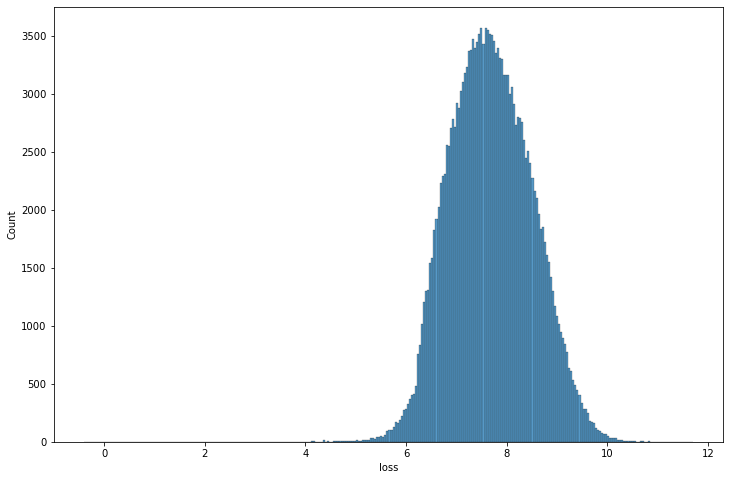

In [29]:
plt.figure(figsize=(12, 8))
sns.histplot(np.log(data_train['loss']))
plt.show()

It is normal now.

### Train test split

In [30]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

D:\anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [31]:
X = data_train.drop(['id', 'loss', 'isTrain'], axis=1)
y = np.log(data_train['loss'])
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
X_train.shape

(141238, 130)

In [33]:
y_train.shape

(141238,)

In [34]:
del X
del y

---
# Modeling
After testing defferent hyperparameters, we now build our model with the following values.

In [52]:
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=12, eval_metric='MAE', verbose=10)

In [53]:
model.fit(X_train, y_train, np.asarray(cat_index) - 1, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6321233	test: 0.6339025	best: 0.6339025 (0)	total: 1.61s	remaining: 2m 39s
10:	learn: 0.4921812	test: 0.4962813	best: 0.4962813 (10)	total: 13.8s	remaining: 1m 51s
20:	learn: 0.4475441	test: 0.4542978	best: 0.4542978 (20)	total: 25.4s	remaining: 1m 35s
30:	learn: 0.4309422	test: 0.4402376	best: 0.4402376 (30)	total: 36.5s	remaining: 1m 21s
40:	learn: 0.4224745	test: 0.4334991	best: 0.4334991 (40)	total: 47.8s	remaining: 1m 8s
50:	learn: 0.4167667	test: 0.4297962	best: 0.4297962 (50)	total: 58.7s	remaining: 56.4s
60:	learn: 0.4124589	test: 0.4272250	best: 0.4272250 (60)	total: 1m 9s	remaining: 44.6s
70:	learn: 0.4092618	test: 0.4257567	best: 0.4257567 (70)	total: 1m 20s	remaining: 32.9s
80:	learn: 0.4061605	test: 0.4244975	best: 0.4244975 (80)	total: 1m 31s	remaining: 21.5s
90:	learn: 0.4036346	test: 0.4236056	best: 0.4236056 (90)	total: 1m 43s	remaining: 10.2s
99:	learn: 0.4012561	test: 0.4228345	best: 0.4228345 (99)	total: 1m 54s	remaining: 0us

bestTest = 0.422834465
best

Best score

In [57]:
best = model.best_score_.get('validation').get('MAE')
best

0.4228344650030103

Actual value

In [68]:
print('MAE:', np.exp(best))

MAE: 1.5262816220301358


---
# Prediction

In [62]:
data_test.drop(['id'], axis=1, inplace=True)

In [64]:
y_pred = model.predict(data_test)

In [65]:
y_pred = np.exp(y_pred)

In [66]:
data_test['loss'] = y_pred

In [67]:
data_test.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,isTrain,loss
0,A,B,A,A,A,A,A,A,B,A,...,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,False,1558.910027
1,A,B,A,B,A,A,A,A,B,A,...,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,False,1949.891908
2,A,B,A,B,B,A,B,A,B,B,...,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,False,7337.218584
3,A,A,A,A,B,A,A,A,A,A,...,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,False,5534.420985
4,B,A,A,A,A,B,A,A,A,A,...,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,False,849.462900


Saving new dataset

In [ ]:
data_test.to_csv('test_predictions.csv')